In [115]:
from datasets import load_dataset
from sentence_transformers import SentenceTransformer, util
from transformers import AutoTokenizer, AutoModel
import torch
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import matplotlib.pyplot as plt

In [99]:
dataset = load_dataset('medical_questions_pairs')
data = dataset['train'].to_pandas()

In [100]:
corpus = pd.concat([data[['question_1', 'question_2', 'label']], data.rename(
    columns={'question_1':'question_2', 'question_2':'question_1'})[['question_2', 'question_1', 'label']]]).drop_duplicates().reset_index(drop=True)

# Диагональная матрица со значениями лейблов
labels_diag_matrix = torch.diag(torch.tensor(corpus['label']))
# Кол-во пар, помеченных 1
cnt_1 = torch.sum(labels_diag_matrix.any(dim=1)).item()

In [102]:
metrics = {}
# Функция, вычисляющая Accuracy@5
def top_n_accuracy(cosine_scores_matrix, labels_diag_matrix, cnt_1, n=3):
    # Найти индексы топ-5 значений в каждой строке
    _, top_indices = torch.topk(cosine_scores_matrix, k=n)
    cnt = 0
    for i in range(len(labels_diag_matrix)):
        if labels_diag_matrix[i][top_indices[i]].any():
            cnt+=1
    result = cnt / cnt_1 if cnt_1 > 0 else 0
    return result

# SentenceTransformer("all-MiniLM-L6-v2")

In [103]:
model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings_1 = model.encode(corpus['question_1'], show_progress_bar=True)
embeddings_2 = model.encode(corpus['question_2'], show_progress_bar=True)

cosine_scores = util.cos_sim(embeddings_1, embeddings_2)
metrics['all-MiniLM-L6-v2'] = top_n_accuracy(cosine_scores, labels_diag_matrix, cnt_1, 5)

Batches:   0%|          | 0/191 [00:00<?, ?it/s]

Batches:   0%|          | 0/191 [00:00<?, ?it/s]

In [104]:
metrics

{'all-MiniLM-L6-v2': 0.9455380577427821}

### То же самое проделаем с Pytorch


In [117]:
# Получим такой же результат, но фрэймворк SentenceTransformer удобнее и быстрее, не нужно отдельно прописывать разделение на батчи
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0]  # First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask


tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")
model = AutoModel.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")

# Tokenize sentences
encoded_input_1 = tokenizer(
    list(corpus['question_1']), padding=True, truncation=True, max_length=128, return_tensors="pt"
)
encoded_input_2 = tokenizer(
    list(corpus['question_2']), padding=True, truncation=True, max_length=128, return_tensors="pt"
)

with torch.no_grad():
    model_output_1 = model(**encoded_input_1)

sentence_embeddings_1 = mean_pooling(model_output_1, encoded_input_1["attention_mask"])

with torch.no_grad():
    model_output_2 = model(**encoded_input_2)

sentence_embeddings_2 = mean_pooling(model_output_2, encoded_input_2["attention_mask"])

cosine_scores = util.cos_sim(sentence_embeddings_1, sentence_embeddings_2)
pytorch_MiniLM = top_n_accuracy(cosine_scores, labels_diag_matrix, cnt_1, 5)
pytorch_MiniLM

0.9455380577427821

# SentenceTransformer("paraphrase-MiniLM-L6-v2")

In [105]:
model = SentenceTransformer("paraphrase-MiniLM-L6-v2")
embeddings_1 = model.encode(corpus['question_1'], show_progress_bar=True)
embeddings_2 = model.encode(corpus['question_2'], show_progress_bar=True)

cosine_scores = util.cos_sim(embeddings_1, embeddings_2)
metrics['paraphrase-MiniLM-L6-v2'] = top_n_accuracy(cosine_scores, labels_diag_matrix, cnt_1, 5)

Batches:   0%|          | 0/191 [00:00<?, ?it/s]

Batches:   0%|          | 0/191 [00:00<?, ?it/s]

In [7]:
metrics

{'all-MiniLM-L6-v2': 0.979002624671916,
 'paraphrase-MiniLM-L6-v2': 0.949475065616798}

# SentenceTransformer("all-mpnet-base-v2")

In [106]:
model = SentenceTransformer("all-mpnet-base-v2")
embeddings_1 = model.encode(corpus['question_1'], show_progress_bar=True)
embeddings_2 = model.encode(corpus['question_2'], show_progress_bar=True)

cosine_scores = util.cos_sim(embeddings_1, embeddings_2)
metrics['all-mpnet-base-v2'] = top_n_accuracy(cosine_scores, labels_diag_matrix, cnt_1, 5)

Batches:   0%|          | 0/191 [00:00<?, ?it/s]

Batches:   0%|          | 0/191 [00:00<?, ?it/s]

In [107]:
metrics

{'all-MiniLM-L6-v2': 0.9455380577427821,
 'paraphrase-MiniLM-L6-v2': 0.8930446194225722,
 'all-mpnet-base-v2': 0.9422572178477691}

# SentenceTransformer("all-MiniLM-L12-v2")

In [108]:
model = SentenceTransformer("all-MiniLM-L12-v2")
embeddings_1 = model.encode(corpus['question_1'], show_progress_bar=True)
embeddings_2 = model.encode(corpus['question_2'], show_progress_bar=True)

cosine_scores = util.cos_sim(embeddings_1, embeddings_2)
metrics['all-MiniLM-L12-v2'] = top_n_accuracy(cosine_scores, labels_diag_matrix, cnt_1, 5)

Batches:   0%|          | 0/191 [00:00<?, ?it/s]

Batches:   0%|          | 0/191 [00:00<?, ?it/s]

In [109]:
metrics

{'all-MiniLM-L6-v2': 0.9455380577427821,
 'paraphrase-MiniLM-L6-v2': 0.8930446194225722,
 'all-mpnet-base-v2': 0.9422572178477691,
 'all-MiniLM-L12-v2': 0.9373359580052494}

# TfidfVectorizer

In [110]:
vectorizer = TfidfVectorizer(stop_words='english')
vector_1 = vectorizer.fit_transform(corpus['question_1'])
vector_2 = vectorizer.transform(corpus['question_2'])

cosine_scores = torch.tensor(cosine_similarity(vector_1, vector_2))
metrics['TfidfVectorizer_stopwords'] = top_n_accuracy(cosine_scores, labels_diag_matrix, cnt_1, 5)

vectorizer = TfidfVectorizer()
vector_1 = vectorizer.fit_transform(corpus['question_1'])
vector_2 = vectorizer.transform(corpus['question_2'])

cosine_scores = torch.tensor(cosine_similarity(vector_1, vector_2))
metrics['TfidfVectorizer'] = top_n_accuracy(cosine_scores, labels_diag_matrix, cnt_1, 5)

In [111]:
metrics

{'all-MiniLM-L6-v2': 0.9455380577427821,
 'paraphrase-MiniLM-L6-v2': 0.8930446194225722,
 'all-mpnet-base-v2': 0.9422572178477691,
 'all-MiniLM-L12-v2': 0.9373359580052494,
 'TfidfVectorizer_stopwords': 0.8143044619422573,
 'TfidfVectorizer': 0.8116797900262467}

# CountVectorizer()

In [112]:
vectorizer = CountVectorizer(stop_words='english')
vector_1 = vectorizer.fit_transform(corpus['question_1'])
vector_2 = vectorizer.transform(corpus['question_2'])

cosine_scores = torch.tensor(cosine_similarity(vector_1, vector_2))
metrics['CountVectorizer_stopwords'] = top_n_accuracy(cosine_scores, labels_diag_matrix, cnt_1, 5)

vectorizer = CountVectorizer()
vector_1 = vectorizer.fit_transform(corpus['question_1'])
vector_2 = vectorizer.transform(corpus['question_2'])

cosine_scores = torch.tensor(cosine_similarity(vector_1, vector_2))
metrics['CountVectorizer'] = top_n_accuracy(cosine_scores, labels_diag_matrix, cnt_1, 5)

In [113]:
metrics

{'all-MiniLM-L6-v2': 0.9455380577427821,
 'paraphrase-MiniLM-L6-v2': 0.8930446194225722,
 'all-mpnet-base-v2': 0.9422572178477691,
 'all-MiniLM-L12-v2': 0.9373359580052494,
 'TfidfVectorizer_stopwords': 0.8143044619422573,
 'TfidfVectorizer': 0.8116797900262467,
 'CountVectorizer_stopwords': 0.7536089238845144,
 'CountVectorizer': 0.5193569553805775}

# Итоги

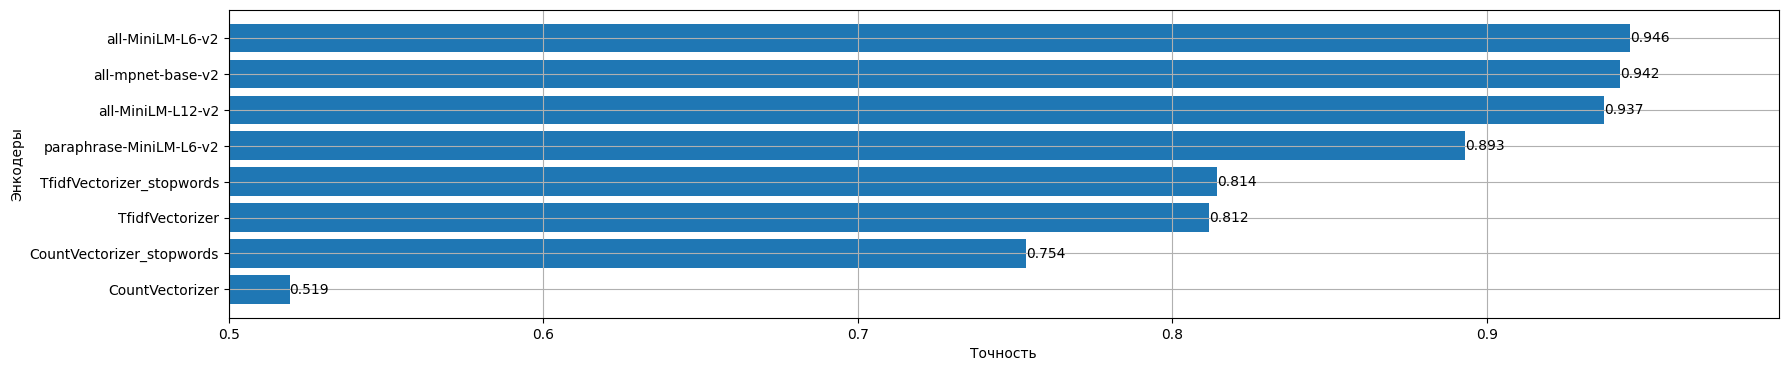

In [114]:
metrics_sorted = dict(sorted(metrics.items(), key=lambda item: item[1]))
plt.figure(figsize=(20, 4))
plt.barh(list(metrics_sorted.keys()), list(metrics_sorted.values()))
plt.xlabel('Точность')
plt.ylabel('Энкодеры')
for i, v in enumerate(metrics_sorted.values()):
    plt.text(v, i, str(round(v,3)), ha='left', va='center')
plt.xlim(0.5)
plt.grid()
plt.show()